<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [97]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Set up paths

In [142]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Competitions/5.RestaurantRevenue/'

train_df_path = gdrive_path + df_path + "train.csv"

# subsamples from train.csv
trainval_sample_processed_path = gdrive_path + df_path + "trainval_sample_processed.csv"
test_sample_processed_path = gdrive_path + df_path + "test_sample_processed.csv" 

test_df_path =  gdrive_path + df_path + "test.csv"
test_processed_path = gdrive_path + df_path + "test_processed.csv"

submission_path = gdrive_path + df_path + "submission.csv"
sample_submission_path = gdrive_path + df_path + "sampleSubmission.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. Frame the problem

- **Type of task?**
    - Supervised / Unsupervised / Reinforcement?
        - Supervised
    - Classification / Regression / Clustering / Novelty search?
        - Regression (univariate, multiple regression)
    - Batch learning / Online learning?
        - Batch learning

- **How company will benefit from task?**
    - **Predicting revenue (money) of a restaurang, to justify investment in building a new one in a given area**

- **Algorithms?**
    - SGD regressor, SVM, Random forest, FFNN, KNN regressor

- **Performance measure?**
    - RMSE
    - MAE if many outliers

- **What the current solution looks like?**
    - Human analysis



# 2. Check assumptions

- No serious assumptions. This competition needs indeed a regression output (values), but not categories or classes.

# 3. Download the data

In [101]:
train_df = pd.read_csv(train_df_path, index_col='Id')
test_df = pd.read_csv(test_df_path, index_col='Id')

# 4. Quick look at data structure

- Outliers and skew in the target variable (revenue)
- Approximately same range of numerical features
- No missing values

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 136
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open Date   137 non-null    object 
 1   City        137 non-null    object 
 2   City Group  137 non-null    object 
 3   Type        137 non-null    object 
 4   P1          137 non-null    int64  
 5   P2          137 non-null    float64
 6   P3          137 non-null    float64
 7   P4          137 non-null    float64
 8   P5          137 non-null    int64  
 9   P6          137 non-null    int64  
 10  P7          137 non-null    int64  
 11  P8          137 non-null    int64  
 12  P9          137 non-null    int64  
 13  P10         137 non-null    int64  
 14  P11         137 non-null    int64  
 15  P12         137 non-null    int64  
 16  P13         137 non-null    float64
 17  P14         137 non-null    int64  
 18  P15         137 non-null    int64  
 19  P16         137 non-null    i

In [ ]:
train_df.describe()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,5.489051,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,1.847561,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,5.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


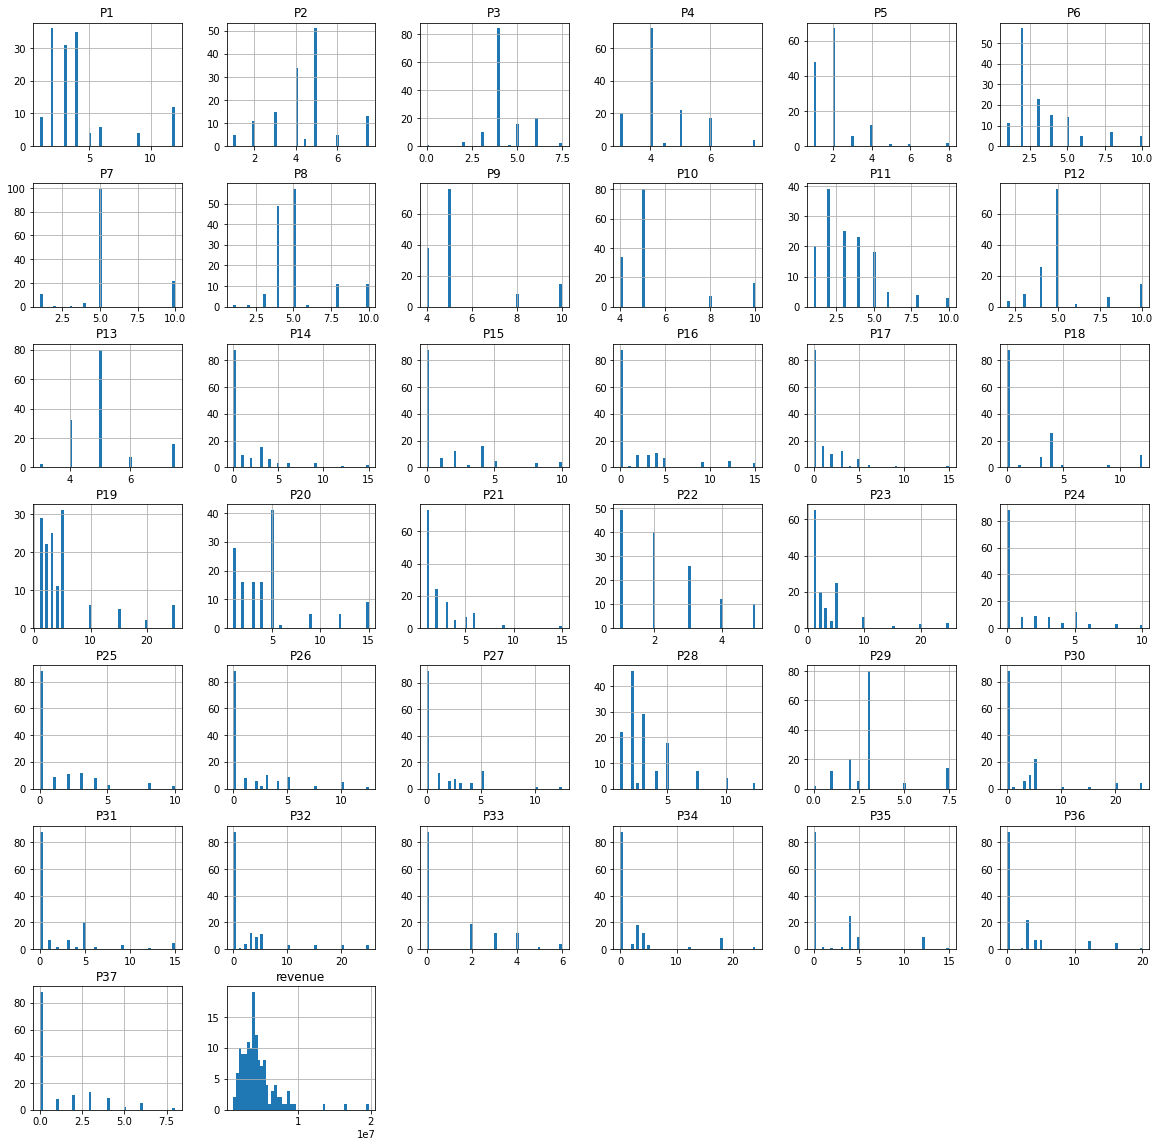

In [ ]:
_ = train_df.hist(bins=50, figsize = (20, 20))

# 5. Create test + trainval sets (remember stratified sampling)

In [102]:
TEST_PERCENTAGE = 0.15
RANDOM_STATE = 42

train_val_sample, test_sample = train_test_split(
    train_df,
    test_size = TEST_PERCENTAGE,
    random_state = RANDOM_STATE,
    # stratify = train_df['revenue'].values
)

Text(0, 0.5, 'Percentage')

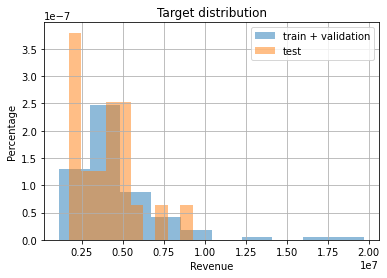

In [103]:
fig, ax = plt.subplots()

ax.hist(train_val_sample['revenue'], density=True, alpha=0.5)
ax.hist(test_sample['revenue'], density=True, alpha=0.5)

ax.legend(['train + validation', 'test'])
ax.grid()
ax.set_title('Target distribution')
ax.set_xlabel('Revenue')
ax.set_ylabel('Percentage')

# 6. Data exploration (from now on: work with trainval set)

- Heavy tail - might log-transform the data. Because many algorithms fail to detect patterns for data with heavy tails
- P28, P6, P17 - log transform
- Big cities contribute to larger revenue (City Group feature). Apply cat encoding, to enforce order
- One hot encoding for the restaurant type. We will not inflate the the dataset, as there are only 4 types of categories
- The majority of restaurants opened after 2007 (skewed). There is an upward trend - the later a restaurant is opened, the more revenue it gives. Replace text feature "Opening date" with numeric feature - year of opening
- Strong correlation with a new feature - population of the city

## 6.1. Sample an exploration set

- Not necessary, dataset is of low size
- **At this step - make a copy of dataset for experiments (for safety)**

In [104]:
exploration_df = train_val_sample.copy()

## 6.2. Visualizations

### 6.2.1. Target variable

(None, None)

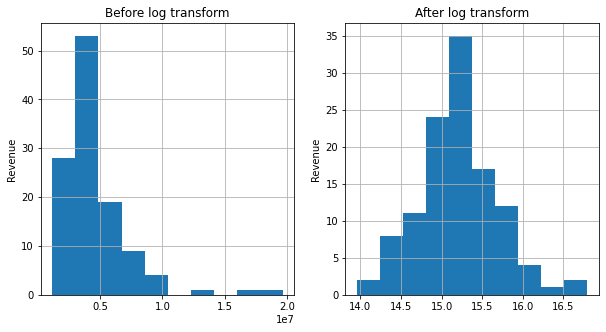

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].hist(exploration_df['revenue'])
ax[0].set_title('Before log transform')
ax[0].set_ylabel('Revenue')

ax[1].hist(np.log(exploration_df['revenue']))
ax[1].set_title('After log transform')
ax[1].set_ylabel('Revenue')

ax[0].grid(), ax[1].grid()

### 6.2.3. Revenue by city

In [106]:
def boxplot_regression(df_, cat_feature_, target_feature_):
    subset = df_[[cat_feature_, target_feature_]]
    s = subset.groupby([cat_feature_]).median().sort_values(by=target_feature_)
    
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(x=cat_feature_, data=df_, stat='percent')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=cat_feature_, y=target_feature_, data=df_, order=s.index)

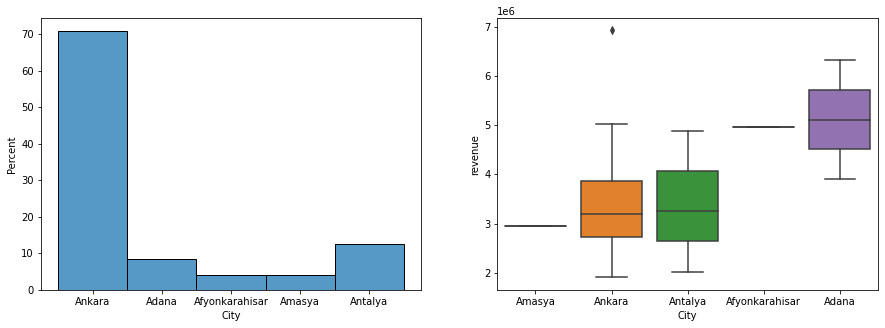

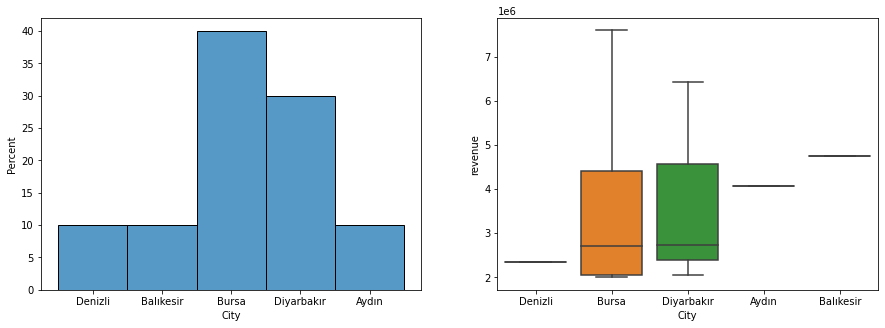

In [107]:
counter = 0
available_cities = np.unique(exploration_df['City'])

boxplot_regression(
    df_=exploration_df.loc[np.isin(exploration_df['City'], available_cities[0:5]), :],
    cat_feature_='City',
    target_feature_='revenue'
)

boxplot_regression(
    df_=exploration_df.loc[np.isin(exploration_df['City'], available_cities[5:10]), :],
    cat_feature_='City',
    target_feature_='revenue'
)

### 6.2.3. Restaurant type

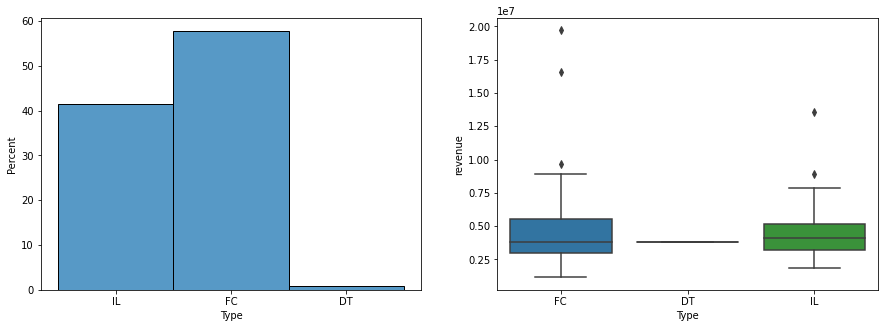

In [108]:
exploration_df['Type'].value_counts()
boxplot_regression(
    df_=exploration_df, 
    cat_feature_='Type', 
    target_feature_='revenue'
)

### 6.2.3. City type

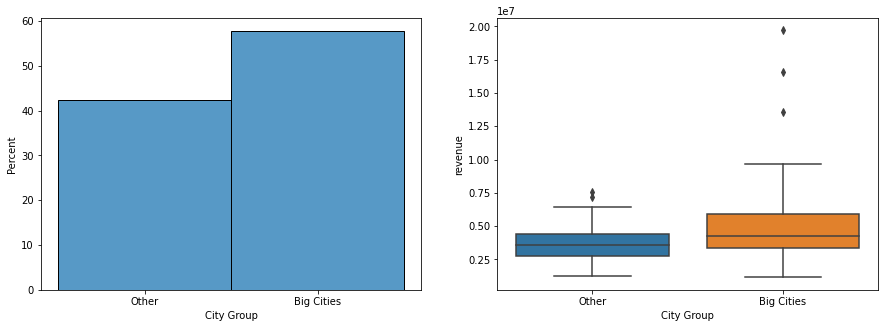

In [109]:
boxplot_regression(exploration_df, 'City Group', 'revenue')

## 6.3. Correlations & scatter matrix

In [ ]:
def get_correlations(df_, target_feature_, ascending_=False):
    cm = df_.corr()
    return cm[target_feature_].sort_values(ascending=ascending_)

def get_correlated_attributes(df_, target_feature_, corr_threshold_):
    '''
    Selects features, that have correlated coeff "C", such that
    |C| > |corr_threshold_|
    '''
    corrs = get_correlations(df_, target_feature_)
    return corrs.loc[
        (corrs >= abs(corr_threshold_)) |
        (corrs <= -abs(corr_threshold_))
    ]


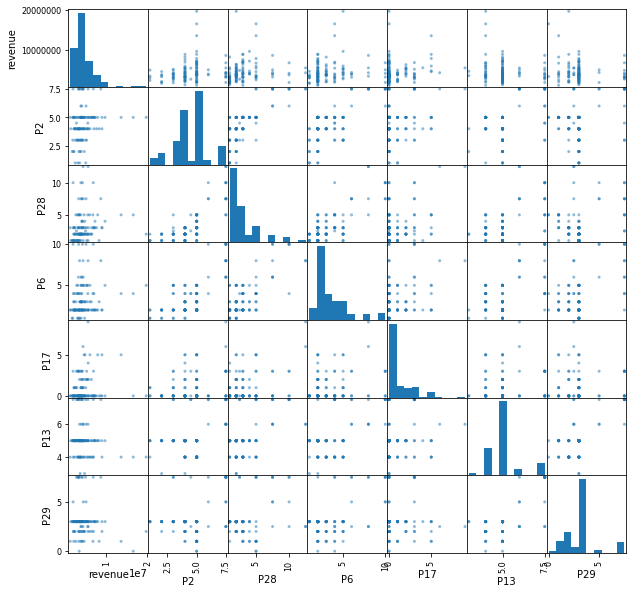

In [ ]:
attributes = get_correlated_attributes(exploration_df, 'revenue', 0.12).index
_ = scatter_matrix(exploration_df[attributes], figsize=(10, 10))

## 6.4. Experiment with attribute combinations

- Not a lot of attributes to combine (unline Housing prices tasks, here we cannot combint P-features). I focus on feature engineering component

## 6.5. Feature engineering

### 6.5.1. Year of opening

In [ ]:
dates = exploration_df['Open Date'].values
years = [int(date.split('/')[-1]) for date in dates]
years[:5]

[2009, 2007, 2008, 2009, 2007]

In [ ]:
exploration_df['open_year'] = years

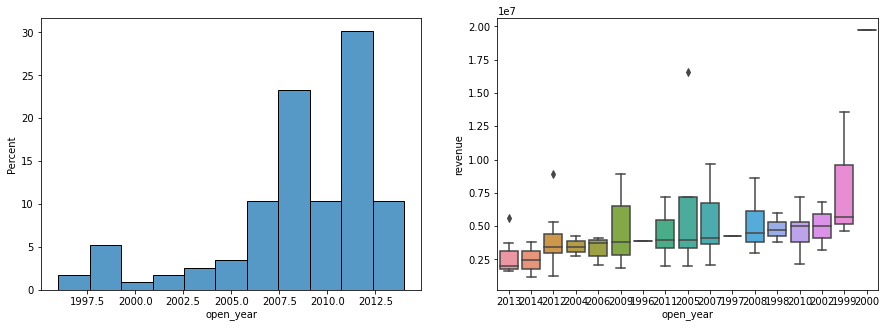

In [ ]:
boxplot_regression(exploration_df, 'open_year', 'revenue')

### 6.5.2. Population

In [ ]:
def write_population(city):
    populations = {
        'Gaziantep' : 2069000,
        'Ankara'    : 5663000,
        'İstanbul'  : 15460000,
        'İzmir'  : 4367000,
        'Kocaeli'  : 2033441,
        'Osmaniye'  : 219339,
        'Kastamonu'  : 128537,
        'Eskişehir'  : 887475,
        'Denizli'  : 1028000,
        'Balıkesir'  : 1229000,
        'Sakarya'  : 567000,
        'Tekirdağ'  : 204001,
        'Bursa'  : 2055000,
        'Kayseri'  : 1062000,
        'Muğla'  : 1000773,
        'Edirne'  : 165979,
        'Samsun'  : 605319,
        'Karabük'  : 248014,
        'Adana'  : 1769000,
        'Afyonkarahisar'  : 744179,
        'Tokat'  : 612646,
        'Amasya'  : 91874,
        'Diyarbakır'   : 1783000,
        'Kütahya'  : 248054,
        'Antalya'   : 1319000,
        'Aydın'   : 1134031,
        'Şanlıurfa'  : 2031000,
        'Kırklareli'  : 88956,
        'Isparta'   : 198385,
        'Uşak'  :  500000,
        'Elazığ'  : 541258
    }
    
    
    assert city in populations.keys()
    return populations[city]

exploration_df['population'] = exploration_df['City'].apply(lambda row: write_population(row))

In [ ]:
get_correlated_attributes(exploration_df, 'revenue', 0.12)

revenue       1.000000
population    0.363098
P2            0.191189
P28           0.150818
P6            0.136381
P17           0.133384
P13          -0.126957
P29          -0.127254
open_year    -0.318152
Name: revenue, dtype: float64

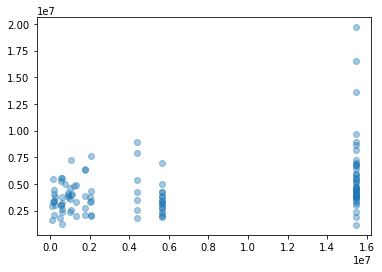

In [ ]:
_, ax = plt.subplots()
ax.scatter(
    x=exploration_df['population'],
    y=exploration_df['revenue'], 
    alpha = 0.4
)

# 7. Data preparation

## Check missing and infinite values

In [110]:
def nan_percentage(df, colname):
    return (df[colname].isnull().sum() / df.shape[0]) * 100

def nan_statistics(df, nan_thresh=0.0):
    res = {}
    nan_cols = df.loc[:, df.isna().any()].columns
    for col in nan_cols:
        res[col] = nan_percentage(df, col)
    print(f'Col -- Nan percentage')
    for key, val in sorted(res.items(), key=lambda item: item[1], reverse=True):
        if val >= nan_thresh * 100:
            print(key, val)
        else:
            del res[key]
    return res

In [111]:
nan_statistics(train_val_sample), nan_statistics(test_sample)

Col -- Nan percentage
Col -- Nan percentage


({}, {})

## Text and categorical attributes

In [113]:
def get_categorical_columns(df_):
    return df_.dtypes[df_.dtypes == 'object']

cat_columns = get_categorical_columns(train_val_sample)
cat_columns

Open Date     object
City          object
City Group    object
Type          object
dtype: object

In [114]:
train_val_sample['City Group'].value_counts()

Big Cities    67
Other         49
Name: City Group, dtype: int64

### City Group


In [115]:
# Apply ordinal encoding. 
# Such that big cities were ranked higher, than other
# areas.

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories = [['Other', 'Big Cities']])
enc.fit(train_val_sample[['City Group']])

OrdinalEncoder(categories=[['Other', 'Big Cities']])

### Type (of restaurant)

In [116]:
from sklearn.preprocessing import OneHotEncoder

In [117]:
one_hot_enc = OneHotEncoder()
one_hot_enc.fit(train_val_sample[['Type']])

OneHotEncoder()

In [118]:
res = one_hot_enc.transform(train_val[['Type']])
res

<116x3 sparse matrix of type '<class 'numpy.float64'>'
	with 116 stored elements in Compressed Sparse Row format>

### City 

- Dropping that column

In [137]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        super().__init__()
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for c in self.columns_to_drop:
            assert c in X.columns
        transformed_df = X.drop(labels=self.columns_to_drop, axis='columns', inplace=False)
        return transformed_df

In [120]:
dropper = ColumnDropper(
    columns_to_drop = ['City']
)

res = dropper.fit_transform(train_val_sample)
assert not 'City' in res.columns
assert 'City' in train_val_sample.columns

Dropping
(116, 42)
(116, 41)


### Open date

- Transform into numerical feature (year of opening)

In [124]:
from sklearn.base import BaseEstimator, TransformerMixin

class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self._column_index = 0 # column_index
    
    def fit(self, X, y=None):
        return self
    
    def get_year(self, date_):
        return int(date_.split('/')[-1])
    
    def transform(self, X, y=None):
        dates = X.loc[:, 'Open Date'].values
        numeric_years = list(map(self.get_year, dates))
        
        res_df = X.copy()
        res_df['Open Date'] = numeric_years
        # X[:, self._column_index] = res
        return res_df

In [125]:
date_transformer = DateTransformer()

In [126]:
res = date_transformer.fit_transform(train_val_sample)

In [128]:
res.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
Id,,,,,,,,,,,,,,,,,,,,,
4,2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0
109,2007,Ankara,Big Cities,FC,2,4.0,3.0,5.0,4,5,...,2.0,0,0,0,0,0,0,0,0,4219263.0
36,2008,Ankara,Big Cities,FC,3,5.0,5.0,3.0,1,5,...,3.0,0,0,0,0,0,0,0,0,3028267.0
89,2009,İstanbul,Big Cities,IL,1,1.0,4.0,3.0,1,2,...,3.0,5,4,4,3,3,4,2,3,2364478.0
100,2007,İstanbul,Big Cities,FC,3,5.0,4.0,4.0,2,5,...,3.0,0,0,0,0,0,0,0,0,9652350.0


## Creating pipeline

In [129]:
# target
target_feature = ['revenue']

# numerical
num_features = train_val_sample.dtypes[
    train_val_sample.dtypes != 'object'
]
num_features.drop('revenue', inplace=True)
num_features = list(num_features.index)

# categorical
cat_features = list(
    train_val_sample.dtypes[
        train_val_sample.dtypes == 'object'
    ].index
)

In [130]:
print(num_features)
print(cat_features)
print(target_feature)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37']
['Open Date', 'City', 'City Group', 'Type']
['revenue']


In [131]:
from sklearn.base import BaseEstimator, TransformerMixin

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        super().__init__()
        self.columns = columns
        self.offset = 1.0
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        transformed = X.copy()
        for c in self.columns:
            assert c in transformed.columns
            transformed[c] = np.log(transformed[c] + self.offset)
        return transformed

In [132]:
from sklearn.base import TransformerMixin, BaseEstimator

class PopulationAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def write_population(self, city):
        populations = {
            'Gaziantep' : 2069000,
            'Ankara'    : 5663000,
            'İstanbul'  : 15460000,
            'İzmir'  : 4367000,
            'Kocaeli'  : 2033441,
            'Osmaniye'  : 219339,
            'Kastamonu'  : 128537,
            'Eskişehir'  : 887475,
            'Denizli'  : 1028000,
            'Balıkesir'  : 1229000,
            'Sakarya'  : 567000,
            'Tekirdağ'  : 204001,
            'Bursa'  : 2055000,
            'Kayseri'  : 1062000,
            'Muğla'  : 1000773,
            'Edirne'  : 165979,
            'Samsun'  : 605319,
            'Karabük'  : 248014,
            'Adana'  : 1769000,
            'Afyonkarahisar'  : 744179,
            'Tokat'  : 612646,
            'Amasya'  : 91874,
            'Diyarbakır'   : 1783000,
            'Kütahya'  : 248054,
            'Antalya'   : 1319000,
            'Aydın'   : 1134031,
            'Şanlıurfa'  : 2031000,
            'Kırklareli'  : 88956,
            'Isparta'   : 198385,
            'Uşak'  :  500000,
            'Elazığ'  : 541258,
            'Bolu': 131264,
            'Konya': 2161000,
            'Trabzon': 312060,
            'Niğde': 341412,
            'Aksaray': 416317,
            'Artvin': 25771,
            'Batman': 348963,
            'Bilecik': 64531,
            'Düzce': 135557,
            'Erzincan': 236034,
            'Erzurum': 767848,
            'Giresun': 100712,
            'Hatay': 1670712,
            'Kahramanmaraş': 547000,
            'Kars': 78100,
            'Kırıkkale': 192473,
            'Kırşehir': 114244,
            'Malatya': 512000,
            'Manisa': 356702,
            'Mardin': 809719,
            'Mersin': 955106,
            'Nevşehir': 303010,
            'Ordu': 229214,
            'Rize': 344359,
            'Siirt': 135350,
            'Sivas': 359219,
            'Tanımsız': 500000, # ??? not in google
            'Yalova': 121479,
            'Zonguldak': 213544,
            'Çanakkale': 328736,
            'Çankırı': 216362,
            'Çorum': 237000
        }
            
            
        assert city in populations.keys(), print(city)
        return populations[city] / 1000000

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['population_million'] = X['City'].apply(
            lambda row: self.write_population(row)
        )
        return transformed_df

In [133]:
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

open_date_pipeline = Pipeline([
    ('dates', DateTransformer())  # to numeric years
])

restaurant_type_pipeline = Pipeline([
    ('one-hot', OneHotEncoder(handle_unknown='ignore'))
])

city_group_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories = [['Other', 'Big Cities']]))
])

city_pipeline = Pipeline([
    ('add-population', PopulationAdder()),
    ('delete', ColumnDropper(columns_to_drop = ['City']))
])

target_pipeline = Pipeline([
    ('log', LogTransformer(columns = target_feature))
])

In [138]:
preprocessor = ColumnTransformer(
    [
        ('num', num_pipeline, num_features),
        ('open-date', open_date_pipeline, ['Open Date']),
        ('city-group', city_group_pipeline, ['City Group']),
        ('restaurant-type', restaurant_type_pipeline, ['Type']),
        ('delete-columns', city_pipeline, ['City']),
        ('target-log', target_pipeline, target_feature)
    ], 
    remainder='drop'
)

In [139]:
# These are the subsets of the training set
trainval_sample_processed = preprocessor.fit_transform(
    train_val_sample
)
test_sample_processed = preprocessor.transform(test_sample)

Dropping
(116, 2)
(116, 1)
Dropping
(21, 2)
(21, 1)


In [140]:
# This is the kaggle test set
test_df['revenue'] = np.ones(test_df.shape[0]) # to avoid bug. because no such column
test_processed = preprocessor.transform(
    test_df
)

Dropping
(100000, 2)
(100000, 1)


# Saving data

In [141]:
def save_data(array_, path_):
    df = pd.DataFrame(array_)
    df.to_csv(path_)

In [143]:
save_data(
    trainval_sample_processed, trainval_sample_processed_path)
save_data(
    test_sample_processed, test_sample_processed_path)
save_data(
    test_processed, test_processed_path)

In [198]:
def visualize_datasets_distributions(
    dataframes_dict_, column_numbers_, grid_width_=3):
    
    n_plots = len(column_numbers_)
    if n_plots % grid_width_ == 0:
        grid_height = int(n_plots / grid_width_)
    else:
        grid_height = int(n_plots / grid_width_) + 1
        
    _, ax = plt.subplots(grid_height, grid_width_, figsize=(10, 10))

    for i in range(grid_height):
        for j in range(grid_width_):
            cur_column_number = i * (grid_width_) + j
            
            if cur_column_number > n_plots:
                return

            columns_data = {}
            for dataset_name, df in dataframes_dict_.items():
                columns_data[dataset_name] = df.values[:, cur_column_number]
            
            
            for dataset_name, data in columns_data.items():
                ax[i, j].hist(data, density=True, alpha=0.3, label=dataset_name)

            ax[i, j].set_title(f'Column {cur_column_number}')
            ax[i, j].legend()

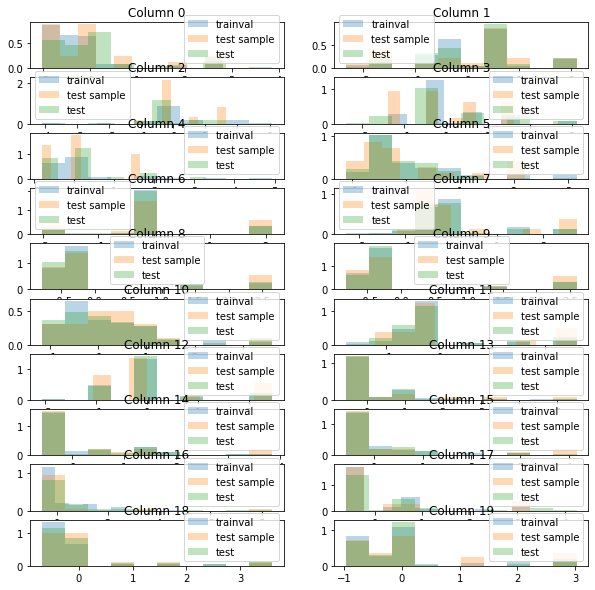

In [201]:
visualize_datasets_distributions(
    {
        'trainval': pd.DataFrame(trainval_sample_processed),
        'test sample': pd.DataFrame(test_sample_processed),
        'test': pd.DataFrame(test_processed)
    },
    column_numbers_ = range(20),
    grid_width_=2
)